In [81]:
import librosa
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import pickle

from numpy import asarray, save, load
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Conv2D, Flatten, Input, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from sklearn.preprocessing import OneHotEncoder

from keras.regularizers import l2

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
DATASET = './Emotions'
SAMPLE_RATE = 22050
SIGNAL_LENGTH = int(SAMPLE_RATE * 1.5) # 1.5 seconds
MFCC_NUM = 65

In [4]:
labels = {
    'Angry': 0,
    'Happy': 1,
    'Sad': 2,
    'Fearful': 3,
    'Disgusted': 4,
    'Neutral': 5,
    'Suprised': 6
}

In [5]:
def remove_silence(signal, threshold=0.005):
    """
    Remove silence at the beginning and at the end of the signal
    """
    for i in range(len(signal)):
        if np.abs(signal[i]) > threshold:
            break
    for j in range(len(signal)-1, 0, -1):
        if np.abs(signal[j]) > threshold:
            break
    return signal[i:j]

In [6]:
def signal_resize(signal, length=SIGNAL_LENGTH):
    """
    Cut the signal to the given length, or pad it with zeros if it is shorter
    """
    length = length
    if len(signal) > length:
        return signal[:length]
    else:
        return np.pad(signal, (0, max(0, length - len(signal))), "constant")

## Preprocesamiento

In [ ]:
data = []
i = 0
start_time = time.time()
for subdir, dirs, files in os.walk(DATASET):
  print('Path: ', subdir)
  print('Class: ', i)
  for file in files:
    X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
    X = remove_silence(X)
    if len(X) == 0:
      continue

    X = signal_resize(X)
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=MFCC_NUM).T
    data.append((mfcc, i))

  if files:
    i = i + 1
    print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

In [7]:
# save('./convolutional.npy', asarray(data), allow_pickle=True)
data = load('./convolutional.npy', allow_pickle=True)

# Clasificador

In [55]:
dim_1 = MFCC_NUM
dim_2 = MFCC_NUM
channel = 1
epochs = 1000
batch_size = 100
verbose = 1
num_classes = len(labels.keys())

In [56]:
X, y = zip(*data)
X = np.asarray(X)
y = np.asarray(y)

In [57]:
x_mean = np.mean(X)
x_std = np.std(X)

In [58]:
#Estandarizar
X_norm = (X - x_mean) / x_std

In [ ]:
# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(y)
# y_norm = enc.transform(y.reshape(-1,-1))

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=True, shuffle=True)
X_test,  X_val,  y_test,  y_val  = train_test_split(X_test, y_test, test_size=0.5, random_state=True, shuffle=True)

In [59]:
model = Sequential()

model.add(Input(shape=(dim_1, dim_2, channel)))
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size=3, strides=2, activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(16, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(16, kernel_size=3, strides=2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(16, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(8, kernel_size=3, strides=2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))

In [60]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 65, 65, 64)        640       
                                                                 
 batch_normalization_51 (Bat  (None, 65, 65, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_81 (Dropout)        (None, 65, 65, 64)        0         
                                                                 
 conv2d_49 (Conv2D)          (None, 33, 33, 64)        36928     
                                                                 
 batch_normalization_52 (Bat  (None, 33, 33, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_82 (Dropout)        (None, 33, 33, 64)       

In [61]:
model.compile(
    optimizer=Adam(learning_rate=0.0001, beta_1=0.5), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [62]:
es = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 1, 
    patience = int(0.1 * epochs)
)

mc = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [63]:
history = model.fit(
    X_train, 
    y_train, 
    epochs = epochs, 
    batch_size = batch_size, 
    validation_data = (X_val, y_val),
    callbacks=[es, mc]
)

Epoch 1/1000
103/103 [==============================] - 9s 64ms/step - loss: 2.2928 - accuracy: 0.1194 - val_loss: 2.0817 - val_accuracy: 0.1547
Epoch 2/1000
103/103 [==============================] - 5s 52ms/step - loss: 2.1541 - accuracy: 0.1411 - val_loss: 2.0725 - val_accuracy: 0.1773
Epoch 3/1000
103/103 [==============================] - 5s 53ms/step - loss: 2.1158 - accuracy: 0.1483 - val_loss: 2.0688 - val_accuracy: 0.1578
Epoch 4/1000
103/103 [==============================] - 5s 53ms/step - loss: 2.0976 - accuracy: 0.1565 - val_loss: 2.0669 - val_accuracy: 0.1578
Epoch 5/1000
103/103 [==============================] - 5s 53ms/step - loss: 2.0887 - accuracy: 0.1553 - val_loss: 2.0620 - val_accuracy: 0.1578
Epoch 6/1000
103/103 [==============================] - 6s 54ms/step - loss: 2.0784 - accuracy: 0.1688 - val_loss: 2.0472 - val_accuracy: 0.1844
Epoch 7/1000
103/103 [==============================] - 6s 55ms/step - loss: 2.0619 - accuracy: 0.1779 - val_loss: 2.0260 - val_ac

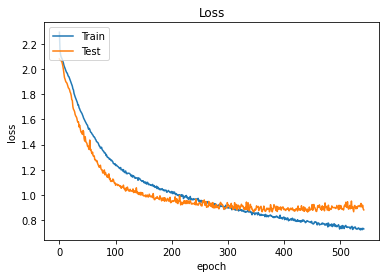

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

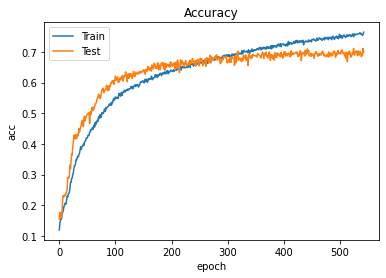

In [65]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluación del modelo

In [66]:
best_model = load_model('best_model.h5')
predictions_best = np.argmax(best_model.predict(X_test),axis=1)
y_test = y_test.astype(int)
report = classification_report(y_test, predictions_best)
print(report)

40/40 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.76      0.90      0.82       245
           1       0.61      0.47      0.53       179
           2       0.68      0.57      0.62       200
           3       0.63      0.62      0.63       213
           4       0.63      0.79      0.70       186
           5       0.73      0.65      0.69       207
           6       0.84      0.94      0.89        50

    accuracy                           0.69      1280
   macro avg       0.70      0.71      0.70      1280
weighted avg       0.68      0.69      0.68      1280



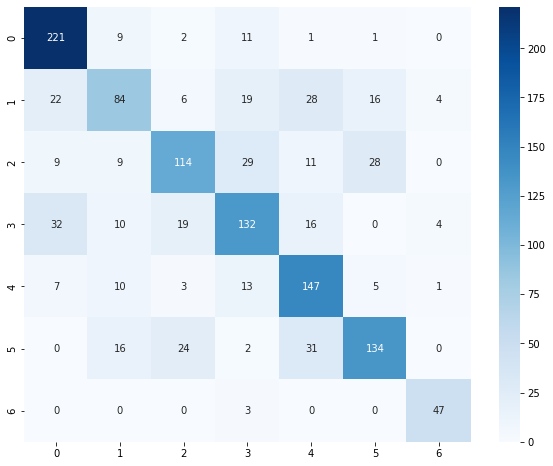

In [80]:
matrix = confusion_matrix(y_test, predictions_best)
plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues')

In [68]:
test_item = X_test[0].reshape(-1, 65, 65, 1)

In [70]:
prediction = best_model.predict(test_item)[0]
prediction

1/1 [==============================] - 0s 35ms/step


array([0.06118721, 0.19245334, 0.10128772, 0.18263263, 0.38403717,
       0.07136399, 0.00703806], dtype=float32)

In [82]:
pickle.dump(best_model, open('convolutional.model','wb'))